In [1]:
import os
import tensorflow as tf

# Set CUDA device order and visible devices
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = "0,1,2,3,4,5,6,7,8,9"

# Set the device
device = '/cpu:0'
if tf.config.experimental.list_physical_devices('GPU'):
    try:
        # Restrict TensorFlow to only use the second GPU
        gpus = tf.config.experimental.list_physical_devices('GPU')
        if gpus:
            tf.config.experimental.set_visible_devices(gpus[8], 'GPU')
            device = '/gpu:8'
    except RuntimeError as e:
        print(e)

print("device", device)


2024-08-28 21:42:17.901757: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-08-28 21:42:17.917304: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-08-28 21:42:17.931118: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-08-28 21:42:17.935350: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-08-28 21:42:17.948423: I tensorflow/core/platform/cpu_feature_guar

device /gpu:8


### Load Dependencies

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import h5py
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers, callbacks
from m3util.ml.rand import set_seeds


### Load Data and Preprocess

In [3]:

class DataLoader:
    def __init__(self, h5_filename):
        self.h5_filename = h5_filename
        self.images, self.centers = self.load_data()

    def load_data(self):
        with h5py.File(self.h5_filename, 'r') as f:
            images = np.array(f['images'][:10000])
            centers = np.array(f['centers_training'][:10000])
        return images, centers

    def plot_image_with_centers(self, image_index=None):
        if image_index is None:
            image_index = np.random.randint(0, len(self.images))

        image = self.images[image_index]
        centers = self.centers[image_index]

        plt.imshow(image, cmap='gray')
        valid_centers = centers[centers[:, 0] == 1]
        for center in valid_centers:
            plt.scatter(center[1], center[2], c='red', marker='x')  # center[1] is x and center[2] is y
        plt.title('Image with Valid Centers Marked')
        plt.colorbar()
        plt.show()

    @staticmethod
    def sort_centers(centers):
        return centers[np.lexsort((centers[:, 0], centers[:, 1]))]

    def normalize_data(self):
        normalized_images = self.images / np.max(self.images)
        sorted_centers = np.array([self.sort_centers(image_centers[:, 1:]) for image_centers in self.centers])
        normalized_centers = sorted_centers / 64
        normalized_midpoints = tf.expand_dims(normalized_centers, axis=1)
        return normalized_images, normalized_midpoints.numpy()

    def split_data(self, train_size=0.8, random_state=42):
        normalized_images, normalized_midpoints_np = self.normalize_data()
        return train_test_split(normalized_images, normalized_midpoints_np, train_size=train_size, random_state=random_state)

### Train/Val Images in DataLoader

In [4]:

def plot_transposed_images_with_midpoints(dataset, image_indices=[0, 1, 2, 3]):
    """
    Extracts multiple images and their midpoints from the given dataset, transposes the images, 
    corrects the midpoints, and plots the transposed images with the corrected midpoints.

    Args:
    - dataset (tf.data.Dataset): The dataset from which to extract the images and midpoints.
    - image_indices (list): The indices of the images in the batch to visualize. Default is [0, 1, 2, 3].
    """

    # Extract a sample image batch and its corresponding midpoints from the dataset
    sample_image_batch, sample_midpoints_batch = next(iter(dataset))

    # Create a figure with 2x2 subplots
    fig, axes = plt.subplots(2, 2, figsize=(6, 6))

    for i, ax in enumerate(axes.flat):
        if i < len(image_indices):
            # Select the specified image and corresponding midpoints from the batch
            sample_image = np.array(sample_image_batch[image_indices[i]])
            sample_midpoints = np.array(sample_midpoints_batch[image_indices[i]])

            # Transpose the image
            transposed_image = sample_image.T

            # Correct the midpoints by swapping the x and y coordinates
            transposed_midpoints_corrected = sample_midpoints[:, :, [1, 0]]

            # Plot the transposed image with corrected midpoints
            ax.imshow(transposed_image, cmap='gray')
            ax.scatter(
                transposed_midpoints_corrected[:, :, 0] * 64, 
                transposed_midpoints_corrected[:, :, 1] * 64, 
                c='red', marker='o',s=5
            )
            ax.set_title(f'Image {image_indices[i]} for this batch')
        else:
            ax.axis('off')  # If fewer than 4 images are requested, hide the unused subplots

    plt.tight_layout()
    plt.show()


### Model Architecture

In [5]:

# class ModelBuilder:
#     def __init__(self, input_shape=(64, 64, 1), num_classes=3, num_coordinates=2, learning_rate=1e-3):
#         self.input_shape = input_shape
#         self.num_classes = num_classes
#         self.num_coordinates = num_coordinates
#         self.learning_rate = learning_rate
#         self.model = self.build_model()
#         self.optimizer = tf.keras.optimizers.Adam(learning_rate=self.learning_rate)

#     def build_model(self):
#         x_input = layers.Input(shape=self.input_shape)
#         x = layers.Conv2D(64, kernel_size=3, padding='same', activation='relu')(x_input)
#         x = layers.MaxPool2D()(x)
#         x = layers.BatchNormalization()(x)
#         x = layers.Conv2D(64, kernel_size=3, padding='same', activation='relu')(x)
        
#         x = layers.Conv2D(128, kernel_size=3, padding='same', activation='relu')(x)
#         x = layers.Conv2D(128, kernel_size=3, padding='same', activation='relu')(x)
#         x = layers.BatchNormalization()(x)
#         x = layers.Dropout(0.2)(x)
        
#         x = layers.Conv2D(256, kernel_size=3, padding='same', activation='relu')(x)
#         x = layers.Conv2D(256, kernel_size=3, padding='same', activation='relu')(x)
#         x = layers.BatchNormalization()(x)
#         x = layers.Dropout(0.2)(x)
        
#         x = layers.Conv2D(512, kernel_size=3, padding='same', activation='relu')(x)
#         x = layers.MaxPool2D()(x)
#         x = layers.BatchNormalization()(x)
#         x = layers.Dropout(0.3)(x)
#         x = layers.Conv2D(512, kernel_size=3, padding='same', activation='relu')(x)
#         x = layers.MaxPool2D()(x)
#         x = layers.BatchNormalization()(x)
#         x = layers.Conv2D(512, kernel_size=3, padding='same', activation='relu')(x)
#         x = layers.MaxPool2D()(x)
#         x = layers.BatchNormalization()(x)
#         x = layers.Dropout(0.3)(x)
        
#         x = layers.Conv2D(256, kernel_size=5, padding='same', activation='relu')(x)
#         x = layers.MaxPool2D()(x)
#         x = layers.BatchNormalization()(x)
#         x = layers.Dropout(0.3)(x)
        
#         x = layers.Flatten()(x)
        
#         x_midpoints = layers.Dense(self.num_classes * self.num_coordinates, activation='sigmoid', name='x_midpoints')(x)
#         x_midpoints_reshape = layers.Reshape((-1, self.num_classes, self.num_coordinates), name='x_midpoints_reshape')(x_midpoints)
        
#         return tf.keras.models.Model(x_input, x_midpoints_reshape)

#     def compile_model(self, loss_function):
#         self.model.compile(optimizer=self.optimizer, loss=loss_function)

#     def train_model(self, train_dataset, val_dataset, epochs, callbacks_list):
#         history = self.model.fit(train_dataset, epochs=epochs, validation_data=val_dataset, callbacks=callbacks_list)
#         return history



In [5]:
class ModelBuilder:
    def __init__(self, input_shape=(64, 64, 1), num_classes=3, num_coordinates=2, learning_rate=1e-3, weights_path=None):
        self.input_shape = input_shape
        self.num_classes = num_classes
        self.num_coordinates = num_coordinates
        self.learning_rate = learning_rate
        self.model = self.build_model()

        # Load weights if a path is provided
        if weights_path is not None:
            self.model.load_weights(weights_path)

        self.optimizer = tf.keras.optimizers.Adam(learning_rate=self.learning_rate)

    def build_model(self):
        x_input = layers.Input(shape=self.input_shape)
        x = layers.Conv2D(64, kernel_size=3, padding='same', activation='relu')(x_input)
        x = layers.MaxPool2D()(x)
        x = layers.BatchNormalization()(x)
        x = layers.Conv2D(64, kernel_size=3, padding='same', activation='relu')(x)
        
        x = layers.Conv2D(128, kernel_size=3, padding='same', activation='relu')(x)
        x = layers.Conv2D(128, kernel_size=3, padding='same', activation='relu')(x)
        x = layers.BatchNormalization()(x)
        x = layers.Dropout(0.2)(x)
        
        x = layers.Conv2D(256, kernel_size=3, padding='same', activation='relu')(x)
        x = layers.Conv2D(256, kernel_size=3, padding='same', activation='relu')(x)
        x = layers.BatchNormalization()(x)
        x = layers.Dropout(0.2)(x)
        
        x = layers.Conv2D(512, kernel_size=3, padding='same', activation='relu')(x)
        x = layers.MaxPool2D()(x)
        x = layers.BatchNormalization()(x)
        x = layers.Dropout(0.3)(x)
        x = layers.Conv2D(512, kernel_size=3, padding='same', activation='relu')(x)
        x = layers.MaxPool2D()(x)
        x = layers.BatchNormalization()(x)
        x = layers.Conv2D(512, kernel_size=3, padding='same', activation='relu')(x)
        x = layers.MaxPool2D()(x)
        x = layers.BatchNormalization()(x)
        x = layers.Dropout(0.3)(x)
        
        x = layers.Conv2D(256, kernel_size=5, padding='same', activation='relu')(x)
        x = layers.MaxPool2D()(x)
        x = layers.BatchNormalization()(x)
        x = layers.Dropout(0.3)(x)
        
        x = layers.Flatten()(x)
        
        x_midpoints = layers.Dense(self.num_classes * self.num_coordinates, activation='sigmoid', name='x_midpoints')(x)
        x_midpoints_reshape = layers.Reshape((-1, self.num_classes, self.num_coordinates), name='x_midpoints_reshape')(x_midpoints)
        
        return tf.keras.models.Model(x_input, x_midpoints_reshape)

    def compile_model(self, loss_function):
        self.model.compile(optimizer=self.optimizer, loss=loss_function)

    def train_model(self, train_dataset, val_dataset, epochs, callbacks_list):
        history = self.model.fit(train_dataset, epochs=epochs, validation_data=val_dataset, callbacks=callbacks_list)
        return history


### Custom Loss Function

In [6]:

@tf.keras.utils.register_keras_serializable()
class DynamicExponentCallback(tf.keras.callbacks.Callback):
    def __init__(self, initial_exponent, increment, update_frequency):
        super().__init__()
        self.exponent = initial_exponent
        self.increment = increment
        self.update_frequency = update_frequency

    def on_epoch_end(self, epoch, logs=None):
        if (epoch + 1) % self.update_frequency == 0:
            self.exponent += self.increment
            print(f"\nEpoch {epoch + 1}: Increasing exponent to {self.exponent}")
            self.model.loss = self.custom_loss(self.exponent)

    def custom_loss(self, exponent):
        def loss(y_true, y_pred):
            diff = tf.abs(y_true - y_pred)
            powered_diff = tf.pow(diff, exponent)
            return tf.reduce_mean(powered_diff)
        return loss

    def get_config(self):
        config = super().get_config().copy()
        config.update({
            'initial_exponent': self.exponent,
            'increment': self.increment,
            'update_frequency': self.update_frequency,
        })
        return config

@tf.keras.utils.register_keras_serializable()
def custom_loss(exponent):
    def loss(y_true, y_pred):
        diff = tf.abs(y_true - y_pred)
        powered_diff = tf.pow(diff, exponent)
        return tf.reduce_mean(powered_diff)
    return loss

In [6]:
# @tf.keras.utils.register_keras_serializable()
# class DynamicExponentCallback(tf.keras.callbacks.Callback):
#     def __init__(self, initial_exponent, increment, update_frequency):
#         super().__init__()
#         self.exponent = initial_exponent
#         self.increment = increment
#         self.update_frequency = update_frequency

#     def on_epoch_end(self, epoch, logs=None):
#         if (epoch + 1) % self.update_frequency == 0:
#             self.exponent += self.increment
#             print(f"\nEpoch {epoch + 1}: Increasing exponent to {self.exponent}")
#             self.model.compile(optimizer=self.model.optimizer, loss=custom_loss(self.exponent))

#     def get_config(self):
#         config = super().get_config().copy()
#         config.update({
#             'initial_exponent': self.exponent,
#             'increment': self.increment,
#             'update_frequency': self.update_frequency,
#         })
#         return config


### Save Checkpoints

In [7]:

class CustomModelCheckpoint(callbacks.Callback):
    def __init__(self, save_freq, save_path):
        super(CustomModelCheckpoint, self).__init__()
        self.save_freq = save_freq
        self.save_path = save_path

    def on_epoch_end(self, epoch, logs=None):
        if (epoch + 1) % self.save_freq == 0:
            self.model.save(self.save_path.format(epoch=epoch + 1))
            print(f"Model saved at epoch {epoch + 1}")


Function to run entire pipeline

In [ ]:


# def main():
#     # Load and prepare the data
#     data_loader = DataLoader('/home/m3-learning/Documents/Research Data/Electron Detection/Data Generated/100KImages_3 electrons_only.h5')
#     train_images, val_images, train_midpoints, val_midpoints = data_loader.split_data()

#     train_dataset = tf.data.Dataset.from_tensor_slices((train_images, train_midpoints))
#     val_dataset = tf.data.Dataset.from_tensor_slices((val_images, val_midpoints))

#     batch_size = 400
#     train_dataset = train_dataset.shuffle(buffer_size=2000, reshuffle_each_iteration=True).batch(batch_size)
#     val_dataset = val_dataset.shuffle(buffer_size=2000).batch(batch_size)

#     # Build and compile the model
#     model_builder = ModelBuilder()
#     dynamic_exponent_callback = DynamicExponentCallback(initial_exponent=3, increment=1, update_frequency=7)
#     model_builder.compile_model(loss_function=dynamic_exponent_callback.custom_loss(3))

#     # Define callbacks
#     save_path = "/home/da886/ElectronCountingProject/weights for custom loss/customlossmodel_epoch_{epoch:02d}.h5"
#     checkpoint_callback = CustomModelCheckpoint(save_freq=200, save_path=save_path)

#     lr_scheduler = tf.keras.callbacks.ReduceLROnPlateau(
#         monitor='val_loss', factor=0.5, patience=5, verbose=1, mode='min', min_lr=7e-15
#     )

#     # Train the model
#     history = model_builder.train_model(
#         train_dataset, val_dataset, epochs=3, callbacks_list=[dynamic_exponent_callback, lr_scheduler, checkpoint_callback]
#     )

#     # Optionally plot an image with its centers
#     data_loader.plot_image_with_centers()


# if __name__ == "__main__":
#     main()


In [8]:



h5_filename = '/home/da886/Electron Counting Extended Arch/Data/Mixed100K_3electrons.h5'### for training
# h5_filename ='/home/da886/Electron Counting Extended Arch/Data/Mixed1K_3_forAnalysis.h5' ### for analysis
data_loader = DataLoader(h5_filename)

images, centers = data_loader.load_data()


Random Image with Midpoints

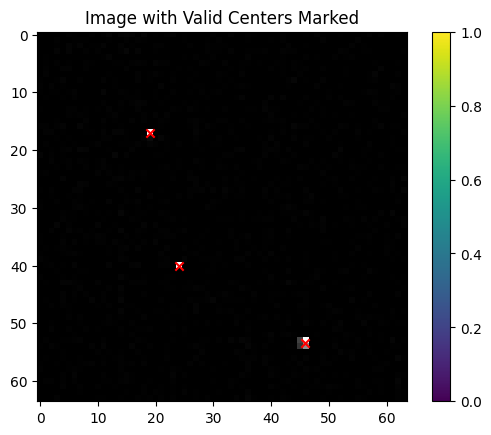

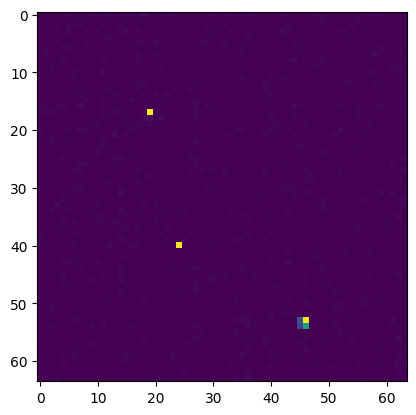

In [9]:
l=np.random.randint(0,len(centers))
data_loader.plot_image_with_centers(l)
plt.imshow(images[l])

In [10]:
# Normalize the data and split it into training and validation sets
train_images, val_images, train_midpoints, val_midpoints = data_loader.split_data()

# Check the shape of the datasets
print(f'Train Images: {train_images.shape}, Train Midpoints: {train_midpoints.shape}')
print(f'Validation Images: {val_images.shape}, Validation Midpoints: {val_midpoints.shape}')


Train Images: (8000, 64, 64), Train Midpoints: (8000, 1, 3, 2)
Validation Images: (2000, 64, 64), Validation Midpoints: (2000, 1, 3, 2)


2024-08-28 21:42:42.200289: I tensorflow/core/common_runtime/gpu/gpu_device.cc:2021] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 79078 MB memory:  -> device: 8, name: NVIDIA A100 80GB PCIe, pci bus id: 0000:ce:00.0, compute capability: 8.0


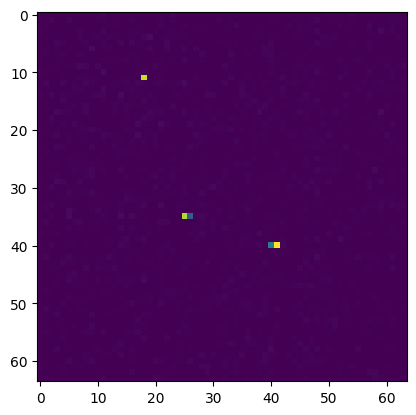

In [11]:
plt.imshow(train_images[1])

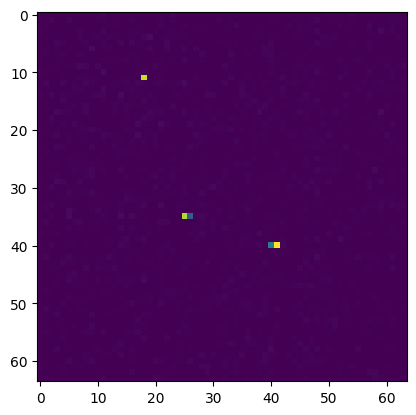

In [10]:
plt.imshow(train_images[1])

In [12]:

train_dataset = tf.data.Dataset.from_tensor_slices((train_images, train_midpoints))
val_dataset = tf.data.Dataset.from_tensor_slices((val_images, val_midpoints))

batch_size = 600
train_dataset = train_dataset.shuffle(buffer_size=2000, reshuffle_each_iteration=True).batch(batch_size)
val_dataset = val_dataset.shuffle(buffer_size=2000).batch(batch_size)


Examples of what goes into the model

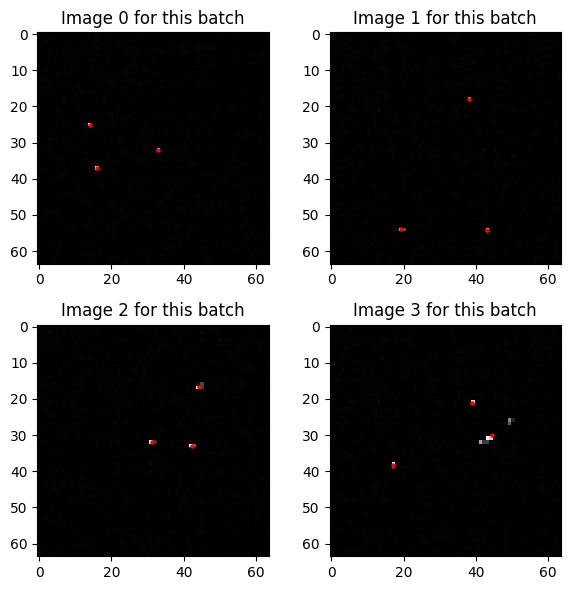

In [13]:
plot_transposed_images_with_midpoints(train_dataset, image_indices=[0, 1, 2, 3])

In [13]:

# Define callbacks
save_path = "/home/da886/ElectronCountingProject/weights for custom loss/customlossmodel_epoch_{epoch:02d}.h5"
checkpoint_callback = CustomModelCheckpoint(save_freq=200, save_path=save_path)

lr_scheduler = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss', factor=0.5, patience=10, verbose=1, mode='min', min_lr=7e-15
)


In [14]:

dynamic_exponent_callback = DynamicExponentCallback(3, 0.5, 7)
# model_builder = ModelBuilder(weights_path='/home/da886/Electron Counting Extended Arch/Weights For Classes/3onlymixed.keras')
model_builder = ModelBuilder()
model_builder.compile_model(loss_function=dynamic_exponent_callback.custom_loss(3))

history = model_builder.train_model(train_dataset, val_dataset, epochs=200, callbacks_list=[dynamic_exponent_callback,lr_scheduler])


Epoch 1/102


I0000 00:00:1724881389.822966   20038 service.cc:146] XLA service 0x13467a30 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1724881389.823030   20038 service.cc:154]   StreamExecutor device (0): NVIDIA A100 80GB PCIe, Compute Capability 8.0
2024-08-28 21:43:09.920535: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-08-28 21:43:10.428954: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:531] Loaded cuDNN version 8907
2024-08-28 21:43:19.426532: E external/local_xla/xla/service/slow_operation_alarm.cc:65] Trying algorithm eng0{} for conv (f32[600,512,16,16]{3,2,1,0}, u8[0]{0}) custom-call(f32[600,512,16,16]{3,2,1,0}, f32[512,512,3,3]{3,2,1,0}), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBackwardInput", backend_config={"operation_queue_id":"0","wait_on_operation_queues

In [16]:

# # Train the model
# history = model.train_model(
#     train_dataset, val_dataset, epochs=63, callbacks_list=[dynamic_exponent_callback, lr_scheduler, checkpoint_callback]
# )


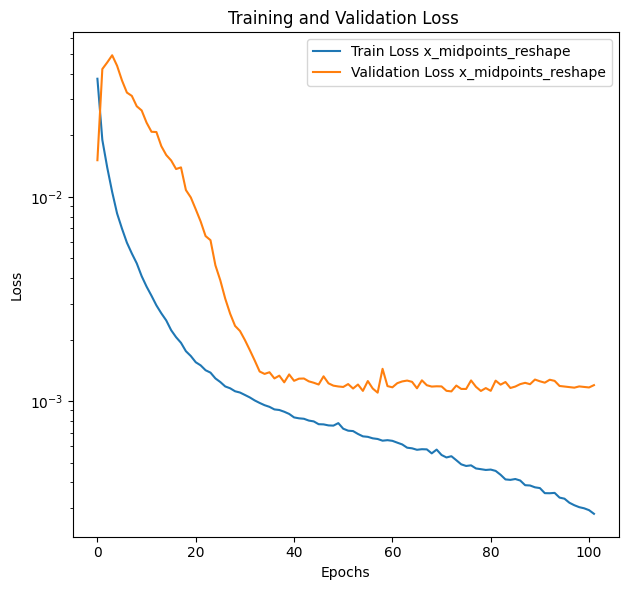

In [16]:


# Extract the losses from the history object
train_loss = history.history['loss']
val_loss = history.history['val_loss']


train_loss_x_midpoints = history.history.get('x_midpoints_reshape_loss', train_loss)
val_loss_x_midpoints = history.history.get('val_x_midpoints_reshape_loss', val_loss)

plt.figure(figsize=(12, 6))
plt.subplot(1, 2,1)
plt.plot(train_loss_x_midpoints, label='Train Loss x_midpoints_reshape')
plt.plot(val_loss_x_midpoints, label='Validation Loss x_midpoints_reshape')
plt.xlabel('Epochs')
plt.yscale('log')

plt.ylabel('Loss')
plt.title('Training and Validation Loss ')
plt.legend()

plt.tight_layout()
plt.show()


In [14]:
loaded_model = tf.keras.models.load_model(
    "/home/da886/Electron Counting Extended Arch/Weights For Classes/3onlymixed.keras",safe_mode=False,
    custom_objects={'DynamicExponentCallback': DynamicExponentCallback, 'custom_loss': custom_loss}
)


/home/da886/anaconda3/envs/objectdetection/lib/python3.11/site-packages/keras/src/saving/saving_lib.py:576: UserWarning: Skipping variable loading for optimizer 'rmsprop', because it has 38 variables whereas the saved optimizer has 74 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


In [17]:
# val_dataset = tf.data.Dataset.from_tensor_slices((val_images, val_midpoints))
# val_dataset = val_dataset.batch(400)
# inputs,targets = next(iter(val_dataset))
# output =loaded_model.predict(inputs)

# train_dataset = tf.data.Dataset.from_tensor_slices((train_images, train_midpoints))
# train_dataset = train_dataset.batch(400)
# inputs,targets = next(iter(train_dataset))
# output =loaded_model.predict(inputs)

train_dataset = tf.data.Dataset.from_tensor_slices((train_images, train_midpoints))
train_dataset = train_dataset.batch(400)
inputs,targets = next(iter(train_dataset))
output =model_builder.model.predict(inputs)

13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 83ms/step


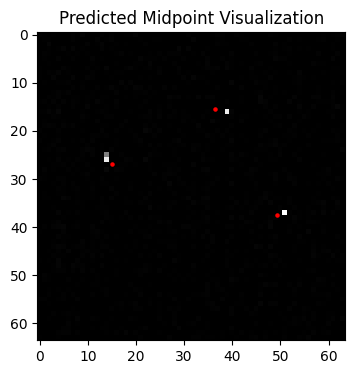

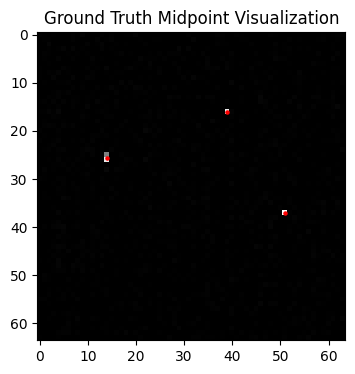

In [33]:
import numpy as np
import matplotlib.pyplot as plt

def visualize_midpoints(image, midpoints):
    """
    Visualizes midpoints on an image without using a probability vector.

    Parameters:
    - image: A 3D tensor representing the image.
    - midpoints: A 2D tensor representing the midpoint coordinates (x, y).

    Returns:
    None (displays the image with midpoints).
    """
    # Convert to NumPy arrays for easier handling
    image_np = image
    midpoints_np = midpoints

    # Denormalize image if necessary (adjust based on your normalization method)
    denormalized_image = image_np  # Modify if normalization was applied during training

    # Visualize the image
    plt.figure(figsize=(4, 4))
    plt.imshow(denormalized_image, cmap='gray')
    plt.title("Predicted Midpoint Visualization")

    # Plot midpoints directly
    for i, (x, y) in enumerate(midpoints_np):
        plt.scatter(x, y, color='red', s=5)

    plt.show()

def visualize_midpoints2(image, midpoints):
    """
    Visualizes ground truth midpoints on an image without using a probability vector.

    Parameters:
    - image: A 3D tensor representing the image.
    - midpoints: A 2D tensor representing the midpoint coordinates (x, y).

    Returns:
    None (displays the image with midpoints).
    """
    
    image_np = image
    midpoints_np = midpoints
    denormalized_image = image_np 

    # Visualize the image
    plt.figure(figsize=(4, 4))
    plt.imshow(denormalized_image, cmap='gray')
    plt.title("Ground Truth Midpoint Visualization")

    # Plot midpoints directly
    for i, (x, y) in enumerate(midpoints_np):
        plt.scatter(x, y, color='red', s=5)

    plt.show()

# Example usage with random data
t = np.random.randint(0, 400)
# t=100

visualize_midpoints(tf.convert_to_tensor(inputs[t]), tf.convert_to_tensor(output[t,0,:,:])*64)
visualize_midpoints2(tf.convert_to_tensor(inputs[t]), tf.convert_to_tensor(targets[t,0,:,:])*64)


In [27]:
loaded_model.compile(optimizer='adam',loss = custom_loss(3))

In [28]:
val_loss = loaded_model.evaluate(val_dataset)
print(f"Validation Loss: {val_loss}")

34/34 ━━━━━━━━━━━━━━━━━━━━ 12s 125ms/step - loss: 6.7416e-04
Validation Loss: 0.0006758289528079331


In [117]:
import numpy as np


mse_values = custom_loss(3)(targets,output) 


In [118]:
min_mse = np.min(mse_values)
min_mse_index = np.argmin(min_mse)

In [125]:
min_mse

9.318346e-11

In [120]:


min_mse_input = inputs[min_mse_index]


In [123]:
min_mse_target = targets[min_mse_index]
min_mse_output = output[min_mse_index]

# print("Minimum MSE:", min_mse)
# print("Corresponding Target:", min_mse_target)
# print("Corresponding Prediction:", min_mse_output)
min_mse_target,min_mse_output


(<tf.Tensor: shape=(1, 3, 2), dtype=float32, numpy=
 array([[[0.828125  , 0.15625   ],
         [0.17910382, 0.19175068],
         [0.7461392 , 0.44389924]]], dtype=float32)>,
 array([[[0.8374564 , 0.14572373],
         [0.171538  , 0.19409983],
         [0.7657308 , 0.43581715]]], dtype=float32))

In [70]:
# import numpy as np
# import tensorflow as tf
# import matplotlib.pyplot as plt

# # Initialize variables to track the least and largest MSE
# min_mse_value = np.inf
# max_mse_value = -np.inf

# best_input = None
# best_target = None
# best_prediction = None

# worst_input = None
# worst_target = None
# worst_prediction = None

# # Iterate over the validation dataset (sample by sample or batch by batch)
# for inputs, targets in val_dataset:  # Assuming processing sample by sample here
#     # Make predictions for the current sample
#     predictions = model_builder.model.predict(inputs)  # Add batch dimension
#     mse = np.mean((predictions - targets) ** 2)
    
#     # Update the minimum MSE if the current one is lower
#     if mse < min_mse_value:
#         min_mse_value = mse
#         best_input = inputs
#         best_target = targets
#         best_prediction = predictions[0]

#     # Update the maximum MSE if the current one is higher
#     if mse > max_mse_value:
#         max_mse_value = mse
#         worst_input = inputs
#         worst_target = targets
#         worst_prediction = predictions[0]

# # Output the results
# print(f"Least MSE: {min_mse_value}")
# print(f"Largest MSE: {max_mse_value}")


In [77]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

# Initialize variables to track the least and largest MSE
min_mse_value = np.inf
max_mse_value = -np.inf

best_input = None
best_target = None
best_prediction = None

worst_input = None
worst_target = None
worst_prediction = None

# Iterate over the validation dataset (sample by sample or batch by batch)
for inputs, targets in val_dataset:  # Assuming processing sample by sample here
    # Make predictions for the current sample
    predictions = model_builder.model.predict(inputs)  # Add batch dimension
    mse = np.mean((predictions - targets) ** 4)
    
    # Update the minimum MSE if the current one is lower
    if mse < min_mse_value:
        min_mse_value = mse
        best_input = inputs[0] if inputs.ndim > 3 else inputs  # Extract the first image if it's a sequence
        best_target = targets[0] if targets.ndim > 2 else targets
        best_prediction = predictions[0]

    # Update the maximum MSE if the current one is higher
    if mse > max_mse_value:
        max_mse_value = mse
        worst_input = inputs[0] if inputs.ndim > 3 else inputs  # Extract the first image if it's a sequence
        worst_target = targets[0] if targets.ndim > 2 else targets
        worst_prediction = predictions[0]

# Output the results
print(f"Least MSE: {min_mse_value}")
print(f"Largest MSE: {max_mse_value}")


19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
19/19 ━━━━━━━━━━━━━━━━━━━

2024-08-28 18:36:58.200285: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


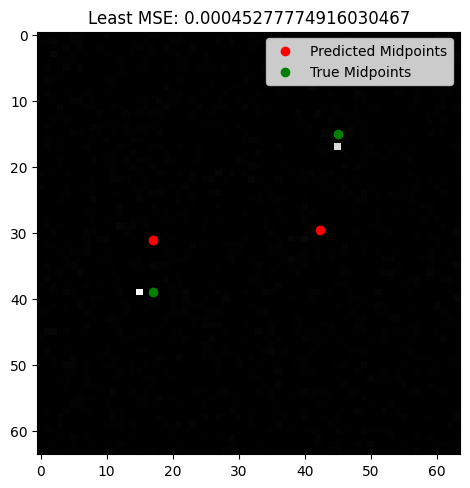

In [79]:

# Visualize the sample with the least MSE
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.title(f"Least MSE: {min_mse_value}")
plt.imshow(best_input[0], cmap='gray')
plt.scatter(best_prediction[:, 0]*64, best_prediction[:, 1]*64, color='r', label='Predicted Midpoints')
plt.scatter(best_target[:, 0]*64, best_target[:, 1]*64, color='g', label='True Midpoints')
plt.legend()


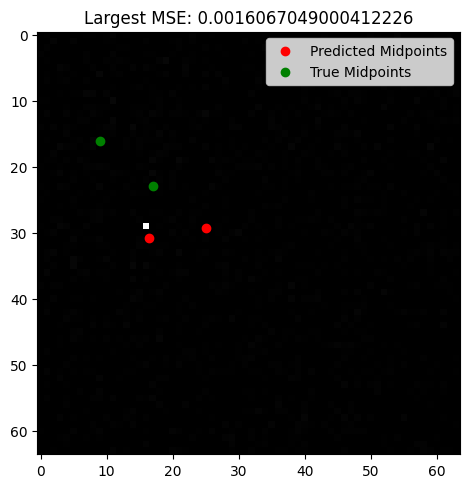

In [83]:

# Visualize the sample with the largest MSE
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 2)
plt.title(f"Largest MSE: {max_mse_value}")
plt.imshow(worst_input[19], cmap='gray')
plt.scatter(worst_prediction[:, 0]*64, worst_prediction[:, 1]*64, color='r', label='Predicted Midpoints')
plt.scatter(worst_target[:, 0]*64, worst_target[:, 1]*64, color='g', label='True Midpoints')
plt.legend()

plt.show()


TypeError: Invalid shape (600, 64, 64) for image data

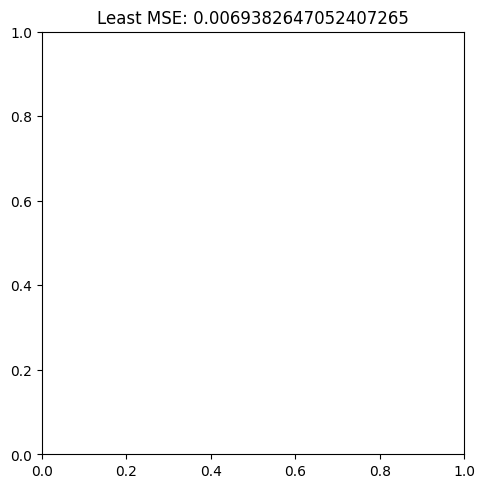

In [69]:

# Visualize the sample with the least MSE
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.title(f"Least MSE: {min_mse_value}")
plt.imshow(best_input, cmap='gray')
plt.scatter(best_prediction[:, 0], best_prediction[:, 1], color='r', label='Predicted Midpoints')
plt.scatter(best_target[:, 0], best_target[:, 1], color='g', label='True Midpoints')
plt.legend()


In [ ]:

# Visualize the sample with the largest MSE
plt.subplot(1, 2, 2)
plt.title(f"Largest MSE: {max_mse_value}")
plt.imshow(worst_input.numpy().squeeze(), cmap='gray')
plt.scatter(worst_prediction[:, 0], worst_prediction[:, 1], color='r', label='Predicted Midpoints')
plt.scatter(worst_target[:, 0], worst_target[:, 1], color='g', label='True Midpoints')
plt.legend()

plt.show()


In [ ]:

# Visualize the sample with the largest MSE
plt.subplot(1, 2, 2)
plt.title(f"Largest MSE: {max_mse_value}")
plt.imshow(worst_input.numpy().squeeze(), cmap='gray')
plt.scatter(worst_prediction[:, 0], worst_prediction[:, 1], color='r', label='Predicted Midpoints')
plt.scatter(worst_target[:, 0], worst_target[:, 1], color='g', label='True Midpoints')
plt.legend()

plt.show()


In [82]:
# model.model.save('/home/da886/Electron Counting Extended Arch/Weights For Classes/3onlymixed.keras')